In [56]:
__author__ = 'Adrian_Radillo'
import numpy as np
import datetime
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
#     y_hot = np.zeros((len(y),2))
#     for i in range(len(y)):
#         if y[i] == 0:
#             y_hot[i,:] = np.array([1,0])
#         else:
#             y_hot[i,:] = np.array([0,1])
    return X, y

def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [58]:
########################################################################################################################
########################################################################################################################
# YOUR ASSSIGMENT STARTS HERE
# FOLLOW THE INSTRUCTION BELOW TO BUILD AND TRAIN A 3-LAYER NEURAL NETWORK
########################################################################################################################
########################################################################################################################
class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    def __init__(self, layer_sizes, num_examples, actFun_type='Tanh', reg_lambda=0.01, seed=0):
        '''
        :param layer_sizes: list of positive integers. 
        :param actFun_type: type of activation function. 3 options: 'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        
        '''
        !!NOTE!! In this code, layer numbering is inverted (this is hidden to the user when he 
        instantiates the class though), therefore the first integer of the list attribute self.layer_sizes
        is dim of output layer and last integer is dimension of the input layer. 
        '''
        self.layer_sizes = list(reversed(layer_sizes))
        self.num_layers = len(self.layer_sizes)
        
        # Instantiate all the layers, except for the input which contains no intrinsic weights.
        layers = {}
        for n in np.arange(1, self.num_layers):
            layers[str(n)] = Layer(layer_size = self.layer_sizes[n - 1], 
                                   prec_layer_size = self.layer_sizes[n], num_examples = num_examples,
                                   seed = seed, depth = n)
            
        # Instantiate input layer separately since no preceding layer
        layers[str(self.num_layers)] = Layer(layer_size = self.layer_sizes[-1], prec_layer_size = 0, 
                                             num_examples = num_examples, seed = seed, 
                                             depth = self.num_layers)
        
        self.layers = layers
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
    def actFun(self, z, type):
        '''
        actFun computes the activation functions
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: activations
        '''
        if type == 'Tanh':
            return np.tanh(z)
        elif type == 'Sigmoid':
            return 1. / (1 + np.exp(-z))
        elif type == 'ReLU':
            return np.maximum(z, np.zeros(z.shape))

    def diff_actFun(self, z, type):
        '''
        diff_actFun computes the derivatives of the activation functions wrt the net input
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''
        if type == 'Tanh':
            return 1 - (self.actFun(z, type))**2
        elif type == 'Sigmoid':
            return self.actFun(z, type) * (1 - self.actFun(z, type))
        elif type == 'ReLU':
            return (z > 0).astype(float)

    def feedforward(self, X, actFun_2):
        '''
        feedforward builds a 3-layer neural network and computes the two probabilities,
        one for class 0 and one for class 1
        :param X: input data
        :param actFun: activation function
        :return:
        '''
        self.layers[str(self.num_layers)].activations = X
        for n in reversed(np.arange(1, self.num_layers)):
            self.layers[str(n)].feedforward(inputs = self.layers[str(n + 1)].activations,
                                                  actFun = actFun_2)
            
        # correct for activations of output layer        
        exp_scores = np.exp(self.layers['1'].linear_output)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        self.layers['1'].activations = self.probs  
        return None

    def calculate_loss(self, X, y):
        '''
        calculate_loss computes the loss for prediction
        :param X: input data
        :param y: given labels
        :return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
#         self.feedforward(X, self.actFun)  # WHY NOT THIS?
        # Calculating the loss
        y_hot = np.array([[1, 0] if yy == 0 else [0, 1] for yy in y])
        data_loss = -np.sum(y_hot * np.log(self.probs)) 

        # Add regulatization term to loss (optional)
        coef = 0
        for L in np.arange(1,self.num_layers):
            coef += np.sum(np.square(self.layers[str(L)].weights))
        data_loss += self.reg_lambda / ((self.num_layers - 1) * coef)
        return (1. / num_examples) * data_loss

    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
        '''
        backprop implements backpropagation to compute the gradients used to update the parameters in the backward step
        :param X: input data
        :param y: given labels
        :return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''
        num_examples = len(X)
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1  
        for L in np.arange(1,self.num_layers):
            if L == 1:
                self.layers[str(L)].backprop(lambda x: self.diff_actFun(x, type=self.actFun_type), 
                                        prev_activations = self.layers[str(L + 1)].activations, 
                                        delta_y = delta3)
            else:
                self.layers[str(L)].backprop(lambda x: self.diff_actFun(x, type=self.actFun_type),
                                        prev_activations = self.layers[str(L + 1)].activations,
                                        post_errors = self.layers[str(L - 1)].error, 
                                        post_weights = self.layers[str(L - 1)].weights)
    
        return None
    
    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: given labels
        :param num_passes: the number of times that the algorithm runs through the whole dataset
        :param print_loss: print the loss or not
        :return:
        '''
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            self.backprop(X, y)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            for L in np.arange(1,self.num_layers):
                self.layers[str(L)].dW += self.reg_lambda * self.layers[str(L)].weights
                
                # Gradient descent parameter update
                self.layers[str(L)].weights += -epsilon * self.layers[str(L)].dW
                self.layers[str(L)].biases += -epsilon * self.layers[str(L)].db
                
            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plots the decision boundary created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary(lambda x: self.predict(x), X, y)

In [59]:
class Layer(object):
    def __init__(self, layer_size, prec_layer_size, num_examples, seed, depth):
        self.num_examples = num_examples
        self.depth = depth
        self.layer_size = layer_size
        self.prec_layer_size = prec_layer_size
        self.linear_output = np.zeros((num_examples, self.layer_size))
        self.activations = np.zeros(self.linear_output.shape)
        self.error = np.zeros((self.num_examples, self.layer_size))
        
        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.weights = np.random.randn(self.prec_layer_size, self.layer_size) / np.sqrt(self.prec_layer_size)
        self.biases = np.zeros((1, self.layer_size)) 
        
        # differentials for weights and biases
        self.dW = np.zeros(self.weights.shape)
        self.db = np.zeros(self.biases.shape)
        
    def backprop(self, diff_actFun, prev_activations, 
                 post_errors = None, post_weights = None, delta_y = None):
        '''
        returns derivative of the loss function with respect to param
        '''
        
        # compute deltas
        if self.depth == 1:
            self.error = delta_y
        else:
            self.error = diff_actFun(self.linear_output) * post_errors.dot(post_weights.T)
            
        # compute weight or bias differential as average over examples
        for example in range(self.num_examples):
            vec1 = prev_activations[example, :]
            vec1.shape = (1, len(vec1))
            vec2 = self.error[example, :]
            vec2.shape = (1, len(vec2))
            self.dW += vec1.T.dot(vec2)
            
        self.dW /= self.num_examples
        self.db = self.error.mean(axis = 0)
        
    def feedforward(self, inputs, actFun):
        self.linear_output = inputs.dot(self.weights) + np.tile(self.biases, (inputs.shape[0], 1))
        self.activations = actFun(self.linear_output)
        return None
        

Loss after iteration 0: 1.215800
Loss after iteration 1000: 0.291953
Loss after iteration 2000: 0.262270
Loss after iteration 3000: 0.230261
Loss after iteration 4000: 0.198338
Loss after iteration 5000: 0.172955
Loss after iteration 6000: 0.155583
Loss after iteration 7000: 0.144192
Loss after iteration 8000: 0.136598
Loss after iteration 9000: 0.131339
Loss after iteration 10000: 0.127539
Loss after iteration 11000: 0.124682
Loss after iteration 12000: 0.122462
Loss after iteration 13000: 0.120688
Loss after iteration 14000: 0.119245
Loss after iteration 15000: 0.118056
Loss after iteration 16000: 0.117069
Loss after iteration 17000: 0.116248
Loss after iteration 18000: 0.115564
Loss after iteration 19000: 0.114997
total time for training (hours:min:sec) 0:01:04


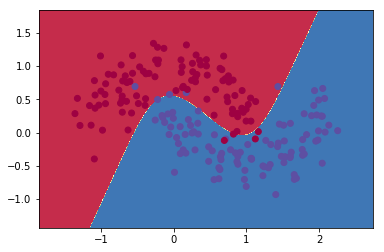

In [60]:
def main():
    # generate and visualize Make-Moons dataset
    X, y = generate_data()
#     plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
#     plt.show()
    model = NeuralNetwork(layer_sizes=[2, 30, 40, 2], num_examples= 200, actFun_type='Tanh')
    # model.fit_model(X,y_hot)
    aa = datetime.datetime.now().replace(microsecond=0)
    model.fit_model(X,y)
    bb = datetime.datetime.now().replace(microsecond=0)
    print('total time for training (hours:min:sec)', bb - aa)
    model.visualize_decision_boundary(X,y)
#     print(np.shape(self.W1), np.shape(self.W2))

if __name__ == "__main__":
    main()

# Derivatives of the various activation functions
In this cell, $f$ always denotes the activation function.
## Derivative of tanh
We have $f(z)=tanh(z)$, with derivative:
$$f'(z)=1-(f(z))^2$$
## Derivative of the sigmoid function
We have $f(z)=1/(1+\exp(-z))$, with derivative:
$$f'(z)=f(z)(1-f(z))$$
## Derivative of the ReLU function
We have $f(z)=\max(0,z)$, with derivative:
$$f'(z)=\left\{\begin{array}{ll}0 & \text{if }z< 0\\ \text{undefined}& \text{if }z=0\\ 1&\text{if }z>0\end{array}\right.$$

$$\frac{\partial \log o_j}{\partial z_k}$$

INSERT RESULTS OF FIRST THREE TRAININGS HERE